![ROOT Logo](http://root.cern.ch/img/logos/ROOT_Logo/website-banner/website-banner-%28not%20root%20picture%29.jpg)
![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)
# **DistROOT Example Notebook**
<hr style="border-top-width: 4px; border-top-color: #34609b;">

Get user credentials.

In [1]:
import getpass
import os, sys

krb5ccname = '/tmp/krb5cc_' + os.environ['USER']
os.environ['KRB5CCNAME'] = krb5ccname

print("Please enter your password")
ret = os.system("echo \"%s\" | kinit -c %s" % (getpass.getpass(), krb5ccname))

if ret == 0: print("Credentials created successfully")
else:        sys.stderr.write('Error creating credentials, return code: %s\n' % ret)

Please enter your password
········
Credentials created successfully


Import Spark modules.

In [2]:
from pyspark import SparkConf, SparkContext

Create Spark configuration and context.

In [3]:
conf = SparkConf()

# Generic for SWAN-Spark prototype
conf.set('spark.driver.host', os.environ['SERVER_HOSTNAME'])
conf.set('spark.driver.port', os.environ['SPARK_PORT_1'])
conf.set('spark.fileserver.port', os.environ['SPARK_PORT_2'])
conf.set('spark.blockManager.port', os.environ['SPARK_PORT_3'])
conf.set('spark.ui.port', os.environ['SPARK_PORT_4'])
conf.set('spark.master', 'yarn')

# DistROOT specific
conf.setAppName("ROOT")
conf.set('spark.executor.extraLibraryPath', os.environ['LD_LIBRARY_PATH'])
conf.set('spark.submit.pyFiles', os.environ['HOME'] + '/DistROOT.py')
conf.set('spark.executorEnv.KRB5CCNAME', krb5ccname)
conf.set('spark.yarn.dist.files', krb5ccname + '#krbcache')

# Resource allocation
conf.set('spark.executor.instances', 4)
conf.set('spark.driver.memory', '2g')

sc = SparkContext(conf = conf)

Import DistROOT.

In [4]:
import ROOT
from DistROOT import DistTree

Welcome to JupyROOT 6.10/04


Define the mapper and reducer functions. In this example, the mapper (`fill`) is in C++ and the reducer (`merge`) is in Python.

In [5]:
%%cpp -d
TH1F* fillHist(TTreeReader& reader) {
    auto h = new TH1F("h", "Example histogram", 100, -4, 4);
    
    TTreeReaderValue<Float_t> px(reader, "px");
    TTreeReaderValue<Float_t> py(reader, "py");
    
    while (reader.Next()) {
        h->Fill(*px + *py);
    }
    
    return h;
}

In [6]:
def mergeHist(h1, h2):
    h1.Add(h2)
    return h1

Build the DistTree and trigger the parallel processing. The final result is the merged histogram.

In [7]:
dTree = DistTree(filelist = ['root://eosproject//eos/project/s/swan/pyroot-spark/data/hsimple.root',],
                 treename = "ntuple",
                 npartitions = 2)

h = dTree.ProcessAndMerge(ROOT.fillHist, mergeHist)

Draw the histogram we filled using Spark and ROOT.

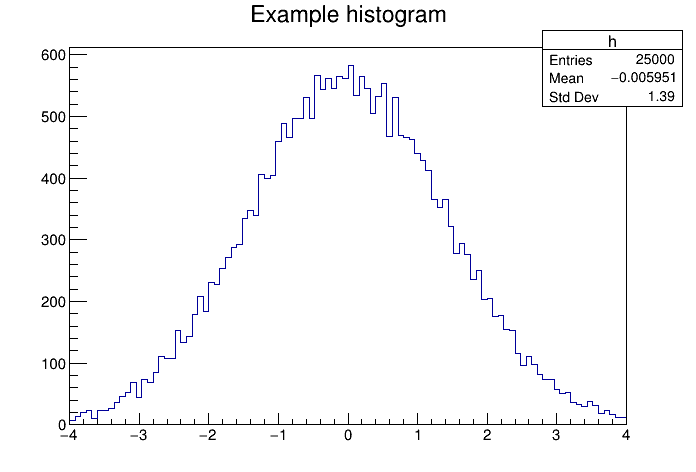

In [8]:
c = ROOT.TCanvas()
h.Draw()
c.Draw()